In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

In [3]:
# Data preparation

# HPI
hpi = pd.read_csv('Data/HPI.csv')
hpi['Date'] = pd.to_datetime(hpi['Date'])

# GDP
gdp = pd.read_csv('Data/GDP.csv')
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp = gdp.set_index('Date')

gdp = gdp.resample('MS').ffill()
start_date = '2000-01-01'
end_date = '2024-12-01'
all_months = pd.date_range(start=start_date, end=end_date, freq='MS')

gdp = gdp.reindex(all_months).ffill()
gdp = gdp.reset_index()
gdp.columns = ['Date', 'GDP']

# CPI
cpi = pd.read_csv('Data/CPI.csv')
cpi['Date'] = pd.to_datetime(cpi['Date'])

# Interest Rates
interest_rates = pd.read_csv('Data/Interest_Rates.csv')
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])

# Unemployment
unemployment = pd.read_csv('Data/Unemployment.csv')
unemployment['Date'] = pd.to_datetime(unemployment['Date'])

# S&P 500
sp500 = pd.read_csv('Data/SP500.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Merge all dataframes on 'Date'
data = pd.merge(hpi, gdp, on='Date', how='outer')
data = pd.merge(data, cpi, on='Date', how='outer')
data = pd.merge(data, interest_rates, on='Date', how='outer')
data = pd.merge(data, unemployment, on='Date', how='outer')
data = pd.merge(data, sp500, on='Date', how='outer')

cols = data.columns.tolist()
second_col = cols[1]
col_reorder = cols[:1] + cols[2:] + [second_col]
data = data[col_reorder]
data.head()


,Date,GDP,CPI,IR,Unemployment,Close,Volume,HPI
0,2000-01-01,378669.0000,2.185792,6.491500,6.8,1394.459961,2.149440e+10,57.2
1,2000-02-01,378669.0000,2.729258,6.338571,6.9,1366.420044,2.091200e+10,57.4
2,2000-03-01,378669.0000,3.043478,6.028261,6.9,1498.579956,2.615620e+10,57.5
3,2000-04-01,383125.8125,2.162162,5.924211,6.7,1452.430054,2.010646e+10,57.6
4,2000-05-01,383125.8125,2.373247,6.215000,6.6,1420.599976,1.989830e+10,57.8


In [4]:
# Create lagged features (1 month lag)
def create_lagged_features(df, lag=1):
    for col in df.columns[1:]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

final_data = create_lagged_features(data, lag=1)
final_data = final_data.drop(['GDP', 'CPI', 'IR', 'Unemployment', 'Close', 'Volume', 'HPI_lag1'], axis=1)
final_data['HPI_lag1'] = final_data['HPI'].shift(1)
final_data['HPI_ma_3'] = final_data['HPI'].rolling(3).mean().shift(1)

In [5]:
# Remove the first row with NaN values
final_data = final_data.dropna()
final_data

,Date,HPI,GDP_lag1,CPI_lag1,IR_lag1,Unemployment_lag1,Close_lag1,Volume_lag1,HPI_lag1,HPI_ma_3
3,2000-04-01,57.6,378669.0000,3.043478,6.028261,6.9,1498.579956,2.615620e+10,57.5,57.366667
4,2000-05-01,57.8,383125.8125,2.162162,5.924211,6.7,1452.430054,2.010646e+10,57.6,57.500000
5,2000-06-01,57.8,383125.8125,2.373247,6.215000,6.6,1420.599976,1.989830e+10,57.8,57.633333
6,2000-07-01,57.9,383125.8125,2.798708,5.895455,6.7,1454.599976,2.173830e+10,57.8,57.733333
7,2000-08-01,58.1,387053.0000,2.900107,5.863500,6.8,1430.829956,1.908910e+10,57.9,57.833333
...,...,...,...,...,...,...,...,...,...,...
296,2024-09-01,125.0,607176.5000,1.953371,3.071500,6.7,5648.399902,8.109730e+10,125.0,124.900000
297,2024-10-01,124.5,607176.5000,1.640379,2.944444,6.6,5762.479980,7.956483e+10,125.0,125.000000
298,2024-11-01,124.6,611103.5000,2.017654,3.186364,6.6,5705.450195,8.241243e+10,124.5,124.833333
299,2024-12-01,124.5,611103.5000,1.889169,3.278500,6.9,6032.379883,8.410198e+10,124.6,124.700000


In [169]:
final_data.describe()

,Date,HPI,GDP_lag1,CPI_lag1,IR_lag1,Unemployment_lag1,Close_lag1,Volume_lag1,HPI_lag1,HPI_ma_3
count,298,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,298.000000,298.000000
mean,2012-08-15 23:16:30.604026880,91.647651,491155.777475,2.230066,3.092190,6.974161,2121.503552,7.057954e+10,91.423154,91.197651
min,2000-04-01 00:00:00,57.600000,378669.000000,-0.949914,0.516364,4.800000,735.090027,1.908910e+10,57.500000,57.366667
25%,2006-06-08 12:00:00,79.200000,446939.000000,1.351517,1.858797,6.200000,1204.452485,4.935718e+10,78.100000,77.150000
50%,2012-08-16 12:00:00,92.200000,485668.000000,2.061392,3.058477,7.000000,1498.344971,7.586021e+10,92.050000,91.933333
75%,2018-10-24 06:00:00,103.200000,546340.578125,2.733291,4.171125,7.475000,2743.637574,8.621590e+10,103.200000,103.200000
max,2025-01-01 00:00:00,126.100000,611103.500000,8.132957,6.215000,14.200000,6032.379883,1.621850e+11,126.100000,126.033333
std,NaN,19.444015,63898.577734,1.392612,1.417251,1.150510,1253.635883,2.869966e+10,19.450795,19.452502


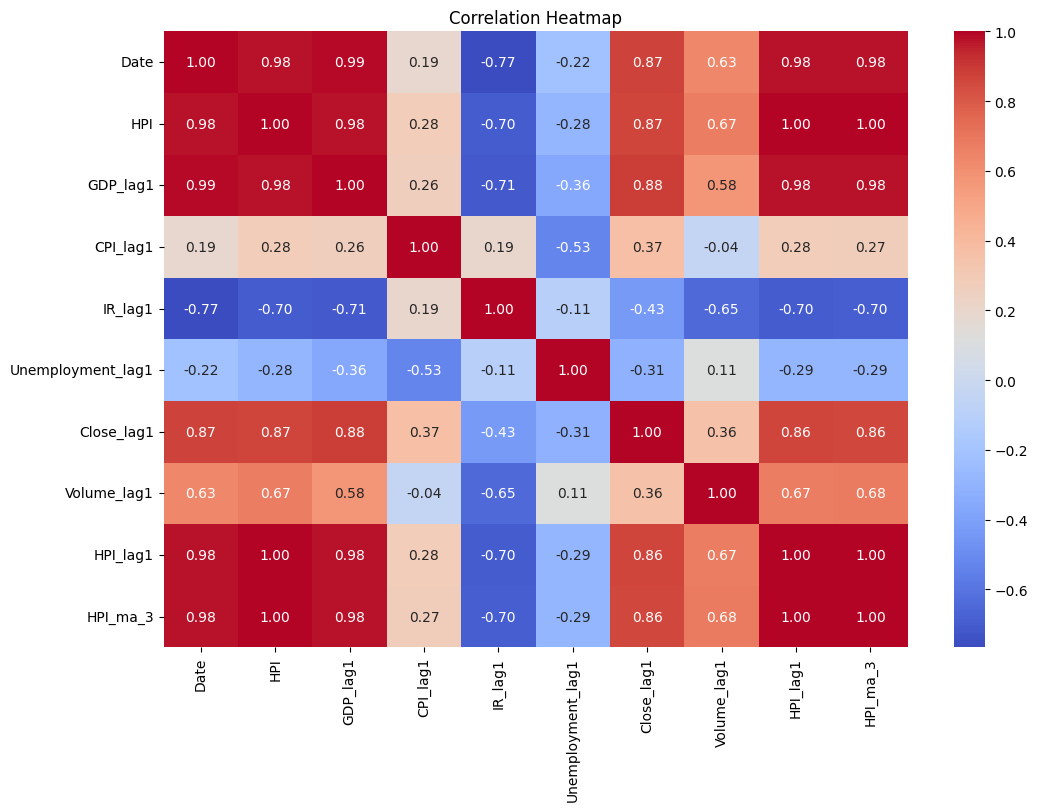

In [170]:
# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(final_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Split the data into features and target variable
features = ['GDP_lag1', 'IR_lag1', 'Unemployment_lag1', 'Close_lag1', 'Volume_lag1', 'HPI_ma_3', 'HPI_lag1']
target =['HPI']

X = final_data[features].values
Y = final_data[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

split_index = int(len(X) * 0.6)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]


In [189]:
# Keep only the features and export the data
final_data.to_csv('model_data.csv', index=False)

In [119]:
len(X_train)

180

In [175]:
NN_model = Sequential()

# Input Layer + first hidden layer
NN_model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))

# Second hidden layer (optional but small)
NN_model.add(Dense(16, activation='relu'))

# Output layer
NN_model.add(Dense(1, activation='linear'))

# Compile the network
NN_model.compile(
    loss='mean_absolute_error',
    optimizer='adam',
    metrics=['mean_absolute_error']
)

NN_model.summary()

/Users/adityamani/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [early_stop]

In [177]:
NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 75.3349 - mean_absolute_error: 75.3349 - val_loss: 93.4711 - val_mean_absolute_error: 93.4711
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 75.0781 - mean_absolute_error: 75.0781 - val_loss: 93.4343 - val_mean_absolute_error: 93.4343
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 75.4409 - mean_absolute_error: 75.4409 - val_loss: 93.3968 - val_mean_absolute_error: 93.3968
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75.7583 - mean_absolute_error: 75.7583 - val_loss: 93.3580 - val_mean_absolute_error: 93.3580
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.0275 - mean_absolute_error: 76.0275 - val_loss: 93.3183 - val_mean_absolute_error: 93.3183
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74.0250 - mean_absolute_error: 74.0250 - val_loss: 93.2766 - val_mean_absolute_error: 93.2766
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 73.9093 - mean_absolute_error: 73.90

In [178]:
test_loss, test_mae = NN_model.evaluate(X_test, Y_test, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.5443 - mean_absolute_error: 19.5443 

Test Loss: 25.0593
Test MAE: 25.0593


NameError: name 'X_test' is not defined

In [179]:
from sklearn.metrics import r2_score
predictions = NN_model.predict(X_test).flatten()
r2 = r2_score(Y_test, predictions)
print(f"R² Score: {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² Score: -5.9763


In [7]:
# fit a multiple linear regression model
mlr = LinearRegression()
mlr.fit(X_train, Y_train)

LinearRegression()

In [11]:
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(mlr, f)

In [10]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [8]:
# make predictions
mlr_predictions = mlr.predict(X_test)
mlr_mse = mean_squared_error(Y_test, mlr_predictions)
mlr_mae = mean_absolute_error(Y_test, mlr_predictions)
mlr_r2 = r2_score(Y_test, mlr_predictions)
print(f"MLR MSE: {mlr_mse:.4f}")
print(f"MLR R² Score: {mlr_r2:.4f}")

MLR MSE: 0.1062
MLR R² Score: 0.9991


In [9]:
X_test

array([[ 3.59880288e-01, -1.10715107e+00, -1.51631893e-01,
        -1.01087063e-01,  2.35607570e-01,  2.21544044e-01,
         2.09950452e-01],
       [ 3.59880288e-01, -1.21051075e+00, -6.45677234e-02,
        -1.35862047e-02, -6.29628255e-02,  2.23260502e-01,
         2.15100278e-01],
       [ 3.59880288e-01, -1.18090384e+00, -6.45677234e-02,
        -4.28384692e-02,  2.12774883e-01,  2.26693418e-01,
         2.20250104e-01],
       [ 3.37878847e-01, -1.18826229e+00,  2.24964466e-02,
        -2.87596160e-02,  5.17042504e-02,  2.30126334e-01,
         2.20250104e-01],
       [ 3.37878847e-01, -9.52871477e-01, -6.45677234e-02,
        -1.12771180e-02, -1.88186080e-01,  2.35275708e-01,
         2.30549755e-01],
       [ 3.37878847e-01, -9.27427460e-01, -6.45677234e-02,
        -4.66576212e-02,  9.19479133e-02,  2.42141541e-01,
         2.40849407e-01],
       [ 3.66660212e-01, -1.07617215e+00,  2.24964466e-02,
        -1.41134886e-02,  2.56219080e-01,  2.50723831e-01,
         2.4599923

In [183]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, preds)
    print(f"{name} MSE: {mse:.4f}")
    print(f"{name} R² Score: {r2_score(Y_test, preds):.4f}")

Ridge MSE: 1.2626
Ridge R² Score: 0.9896
Lasso MSE: 0.7489
Lasso R² Score: 0.9938
ElasticNet MSE: 16.3466
ElasticNet R² Score: 0.8655


/Users/adityamani/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.856e+00, tolerance: 2.864e+00
  model = cd_fast.enet_coordinate_descent(


In [148]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(Lasso(), params, scoring='r2')
lasso_cv.fit(X_train, Y_train)

print(f"Best alpha: {lasso_cv.best_params_['alpha']}")
print(f"Best CV R² Score: {lasso_cv.best_score_:.4f}")

Best alpha: 0.1
Best CV R² Score: -0.6972


In [149]:
# fit a xgboost 
from xgboost import XGBRegressor
xgb_model = XGBRegressor()

xgb_model.fit(X_train, Y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(Y_test.flatten(), xgb_predictions)
xgb_mae = mean_absolute_error(Y_test.flatten(), xgb_predictions)
xgb_r2 = r2_score(Y_test.flatten(), xgb_predictions)

print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")

XGBoost MSE: 354.5425
XGBoost MAE: 15.0642
XGBoost R² Score: -1.9164


In [131]:
xgb_predictions

array([95.26669 , 95.28586 , 95.31148 , 94.87456 , 94.86385 , 94.85563 ,
       95.314705, 95.34702 , 95.26127 , 95.258804, 95.331154, 95.36904 ,
       95.44616 , 95.47672 , 95.46093 , 95.329445, 95.321236, 95.33401 ,
       95.43621 , 95.32394 , 95.41973 , 95.45796 , 95.4937  , 95.41269 ,
       95.42973 , 95.41605 , 95.4333  , 95.450615, 95.43376 , 95.32397 ,
       95.500565, 95.50275 , 95.46353 , 95.513596, 95.49254 , 95.49799 ,
       95.34299 , 95.29196 , 95.438416, 95.29852 , 95.2544  , 95.2849  ,
       95.48719 , 95.23341 , 95.34944 , 95.244644, 95.34929 , 95.5422  ,
       95.45243 , 95.529625, 95.42791 , 95.433304, 95.41325 , 95.43168 ,
       95.43168 , 95.431145, 95.42674 , 95.41649 , 95.4412  , 95.45001 ,
       95.41325 , 95.43986 , 95.20974 , 92.30162 , 92.92249 , 92.3116  ,
       95.203896, 95.21903 , 95.229904, 95.23127 , 95.25119 , 95.24229 ,
       95.43493 , 95.48063 , 95.371666, 95.39381 , 95.42928 , 95.408195,
       95.43348 , 95.4361  , 95.44357 , 95.41101 , 

In [133]:
Y_test.flatten()

array([ 95.6,  95.7,  95.7,  95.9,  96.1,  96.2,  96.5,  96.6,  96.8,
        96.9,  97. ,  97.1,  97.3,  97.5,  97.7,  98.5,  98.6,  99. ,
        99.1,  99.3,  99.7,  99.9, 100. , 100.1, 100.5, 100.7, 101.5,
       102.2, 102.4, 102.8, 102.9, 103.1, 103.2, 103.3, 103.3, 103.3,
       103.1, 103.1, 103.1, 103.1, 103.2, 103.3, 103.3, 103.3, 103.3,
       103.3, 103.3, 103.2, 103.2, 103.2, 103.2, 103.1, 103. , 102.9,
       103. , 103.2, 103.3, 103.2, 103.4, 103.4, 103.8, 104.1, 104.1,
       104.2, 104.3, 104.7, 105.2, 106.5, 107.3, 107.9, 108.2, 109. ,
       111.1, 112.3, 114.4, 116. , 116.7, 117.2, 118. , 118.5, 119.6,
       120.5, 120.8, 121.9, 123.2, 124.7, 125.1, 125.7, 125.9, 126. ,
       126.1, 126. , 125.7, 125.5, 125.5, 125.2, 124.9, 124.9, 124.8,
       124.9, 125. , 124.9, 125. , 124.7, 124.7, 124.4, 124.4, 124.3,
       124.4, 124.4, 124.7, 124.9, 124.7, 125. , 125. , 125. , 124.5,
       124.6, 124.5, 124.4])